In [3]:
import pandas as pd
import numpy as np
import math
import time
import warnings
warnings.filterwarnings("ignore")
import multiprocessing as mp

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

import constant
import tools
import myplot 
from features import Features

# 1. Load Files

In [4]:
settlement = pd.read_parquet(constant.settlement_2019_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv("data/windmill_park_cleaned.csv", dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

ws10 = pd.read_parquet(constant.ws10_path)
ws100 = pd.read_parquet(constant.ws100_path)
wd10 = pd.read_parquet(constant.wd10_path)
wd100 = pd.read_parquet(constant.wd100_path)

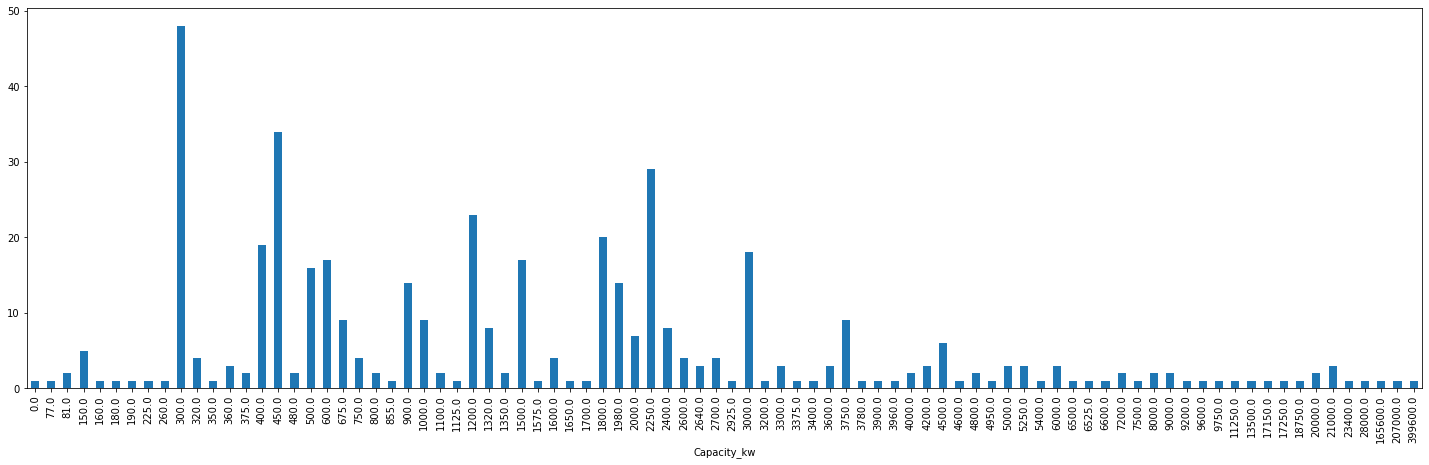

In [5]:
plt.figure(figsize=(25,7))
windmill.groupby("Capacity_kw").count()["GSRN"].plot.bar()

In [6]:
windmill[windmill["Capacity_kw"] == 3000]

,GSRN,BBR_municipal,Placement,Capacity_kw,Elevation,Slope,Aspect,grid,Roughness,Rotor_diameter_group,Navhub_height_group,Elevation_group,Slope_group,Aspect_group,Roughness_group,Navhub_height,Rotor_diameter
20,570715000000013317,851,LAND,3000.0,2.795000,2.176750,38.834,1163,0.10,"[44.0, 44.0, 44.0, 44.0]","[46.0, 46.0, 45.0, 46.5]","[2.8, 2.48, 2.9, 3.0]","[2.9939999999999998, 2.311, 1.515, 1.886999999...","[278.913, 279.151, 92.169, 154.9]","[0.1, 0.1, 0.1, 0.1]",45.875,44.00
41,570715000000019920,730,LAND,3000.0,48.972500,2.503750,308.060,1076,0.10,"[48.0, 48.0, 48.0, 48.0]","[45.0, 45.0, 45.0, 45.0]","[47.64, 54.4, 39.85, 54.0]","[5.004, 2.6069999999999998, 2.404, 0.0]","[265.151, 25.156999999999996, 132.75, -1.0]","[0.1, 0.1, 0.1, 0.1]",45.000,48.00
65,570715000000055218,420,LAND,3000.0,42.887500,4.250000,11.880,942,0.10,"[48.0, 48.0, 48.0, 48.0]","[50.0, 50.0, 50.0, 50.0]","[41.45, 40.1, 46.0, 44.0]","[9.565, 2.464, 3.707, 1.264]","[113.411, 115.34200000000001, 106.374, 118.8]","[0.1, 0.1, 0.1, 0.1]",50.000,48.00
120,570715000000013553,810,LAND,3000.0,7.632500,0.880500,-1.000,1122,0.10,"[44.0, 44.0, 44.0, 44.0]","[46.0, 46.0, 46.0, 46.0]","[7.0, 8.0, 7.647, 7.882999999999999]","[0.0, 0.863, 0.504, 2.155]","[-1.0, 42.887, 0.396, 269.60200000000003]","[0.1, 0.1, 0.1, 0.1]",46.000,44.00
170,570715000000019586,730,LAND,3000.0,51.772000,1.470800,149.416,1075,0.10,"[48.0, 48.0, 48.0, 48.0, 48.0]","[46.0, 46.0, 46.0, 45.0, 45.0]","[51.0, 53.0, 52.0, 51.86, 51.0]","[1.669, 2.449, 0.496, 2.5269999999999997, 0.213]","[264.318, 234.543, 153.84, 319.175, 46.46]","[0.1, 0.1, 0.1, 0.1, 0.1]",45.600,48.00
176,570715000000022630,707,LAND,3000.0,18.330400,1.459800,142.181,991,0.18,"[43.0, 43.0, 43.0, 43.0, 43.0]","[46.0, 46.0, 46.0, 46.0, 46.0]","[20.651999999999997, 18.0, 17.0, 19.0, 17.0]","[2.917, 2.49, 0.0, 1.068, 0.8240000000000001]","[159.179, 58.473, -1.0, 245.72, 138.585]","[0.3, 0.1, 0.1, 0.3, 0.1]",46.000,43.00
197,570715000000038549,665,LAND,3000.0,8.800000,0.124400,-1.000,1325,0.10,"[43.0, 43.0, 43.0, 43.0, 43.0]","[46.0, 46.0, 46.0, 46.0, 46.0]","[9.0, 9.0, 9.0, 9.0, 8.0]","[0.0, 0.0, 0.0, 0.0, 0.622]","[-1.0, -1.0, -1.0, -1.0, 73.454]","[0.1, 0.1, 0.1, 0.1, 0.1]",46.000,43.00
229,570715000000038426,665,LAND,3000.0,7.984200,0.843800,-1.000,1325,0.14,"[44.0, 44.0, 44.0, 44.0, 44.0]","[45.0, 45.0, 45.0, 45.0, 45.0]","[9.0, 6.0, 8.0, 7.0, 9.921]","[0.0, 1.413, 1.083, 1.61, 0.113]","[-1.0, 98.38, 186.804, 150.092, 18.05700000000...","[0.1, 0.1, 0.1, 0.1, 0.3]",45.000,44.00
231,570715000000022999,741,LAND,3000.0,11.730333,1.594333,-0.236,946,0.10,"[54.0, 54.0, 54.0]","[50.0, 50.0, 50.0]","[12.0, 12.190999999999999, 11.0]","[0.899, 2.404, 1.48]","[120.74700000000001, 315.0, -0.483]","[0.1, 0.1, 0.1]",50.000,54.00
255,570715000000019470,730,LAND,3000.0,37.324000,1.210200,161.213,1075,0.10,"[43.0, 43.0, 43.0, 43.0, 43.0]","[46.0, 46.0, 46.0, 46.0, 46.0]","[38.0, 40.62, 30.0, 43.0, 35.0]","[0.94, 1.5490000000000002, 2.432, 0.605, 0.525]","[62.023, 141.343, 145.584, 21.65, 33.725]","[0.1, 0.1, 0.1, 0.1, 0.1]",46.000,43.00


In [7]:
windmill = windmill[windmill["GSRN"] == "570715000000064494"]

### Aggregate windmill and settlement

In [8]:
df = pd.merge(windmill, settlement, on="GSRN")

# 2. Feature Extraction

In [9]:
feat_tool = Features(wu10, wv10, wu100, wv100)
df = feat_tool.extract(df)

145.85681009292603


# Analysis
## Compare Roughness and Wind Shear

In [ ]:
def Evaluation(df, len):
    print("MAE: ", sum(df) / len)
    print("MSE: ", sum(df ** 2) / len)
    print("RMSE: ", (sum(df ** 2) / len) ** 0.5)

In [ ]:
Evaluation(abs(df_1["Roughness"] - df_1["wsr"]), len(df_1))

In [ ]:
Evaluation(abs(df_2["Roughness"] - df_2["wsr"]), len(df_2))

## Slope, Aspect, Roughness

In [ ]:
(df['wsr'] / (df['Slope'] + df['Aspect'] + df['Roughness'])).describe()

In [ ]:
SlopeSlope

In [ ]:
df["Geo"] = df['Slope'] + df['Aspect'] + df['Roughness']
df["Geo"] = df["Geo"] * (df['wsr'] / df["Geo"]).median()

In [ ]:
get_ws_hub_geo_u = lambda x,fun :fun(x["wu10"], 10, x["Navhub_height"], x["Geo"])
get_ws_hub_geo_v = lambda x,fun :fun(x["wv10"], 10, x["Navhub_height"], x["Geo"])

In [ ]:
df["hws_u_geo"] = df.apply(lambda x: get_ws_hub_geo_u(x, pow_law), axis=1)
df["hws_v_geo"] = df.apply(lambda x: get_ws_hub_geo_v(x, pow_law), axis=1)
df["hws_uv_geo"] = df.apply(lambda x: get_ws_by_uv(x["hws_u_geo"], x["hws_v_geo"]), axis=1)

## Compare Hub height Wind Speed by Roughness and by Wind Shear

## Wind Speed - Windmill Power Curve

In [45]:
def wind_power_scatter(df_wsr, df_rn):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(28, 14))

    axs[0].set_title("Windmill Wind Shear")
    axs[0].scatter(df_wsr["hws_uv_wsr"], df_wsr["VAERDI"], color='C0')
    axs[0].plot(df_wsr["hws_uv_wsr"], df_wsr["hws_uv_wsr_q0.7"], color='green', linewidth=2.5)
    axs[0].plot(df_wsr["hws_uv_wsr"], df_wsr["hws_uv_wsr_q0.5"], color='red', linewidth=2.5)
    axs[0].plot(df_wsr["hws_uv_wsr"], df_wsr["hws_uv_wsr_q0.3"], color='blue', linewidth=2.5)
    # axs[0].set_xlim(xlim)
    axs[0].set_xlabel("Wind Speed (m/s)")
    axs[0].set_ylabel("Generation Power (kw)")

    axs[1].set_title("Windmill Roughness")
    axs[1].scatter(df_rn["hws_uv_rn"], df_rn["VAERDI"], color='C1')
    axs[1].plot(df_rn["hws_uv_rn"], df_rn["hws_uv_rn_q0.7"], color='green', linewidth=2.5)
    axs[1].plot(df_rn["hws_uv_rn"], df_rn["hws_uv_rn_q0.5"], color='red', linewidth=2.5)
    axs[1].plot(df_rn["hws_uv_rn"], df_rn["hws_uv_rn_q0.3"], color='blue', linewidth=2.5)
    # axs[1].set_xlim(xlim)
    axs[1].set_xlabel("Wind Speed (m/s)")
    axs[1].set_ylabel("Generation Power (kw)")
    # axs[1].legend()

In [32]:
df.columns

Index(['GSRN', 'BBR_municipal', 'Placement', 'Capacity_kw', 'Elevation',
       'Slope', 'Aspect', 'grid', 'Roughness', 'Rotor_diameter_group',
       'Navhub_height_group', 'Elevation_group', 'Slope_group', 'Aspect_group',
       'Roughness_group', 'Navhub_height', 'Rotor_diameter', 'VAERDI',
       'TIME_CET', 'predicted_ahead', 'wu10', 'wv10', 'wu100', 'wv100',
       'wsr_u', 'wsr_v', 'hws_u_rn', 'hws_v_rn', 'hws_uv_rn', 'hws_u_wsr',
       'hws_v_wsr', 'hws_uv_wsr', 'hws_uv_rn^2', 'hws_uv_rn^3', 'hws_uv_wsr^2',
       'hws_uv_wsr^3', 'hws_uv_rn_q0.1', 'hws_uv_rn_q0.3', 'hws_uv_rn_q0.5',
       'hws_uv_rn_q0.7', 'hws_uv_rn_q0.9', 'hws_uv_wsr_q0.1',
       'hws_uv_wsr_q0.3', 'hws_uv_wsr_q0.5', 'hws_uv_wsr_q0.7',
       'hws_uv_wsr_q0.9', 'month', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7',
       'm8', 'm9', 'm10', 'm11', 'm12', 'hour', 'h0', 'h1', 'h2', 'h3', 'h4',
       'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15',
       'h16', 'h17', 'h18', 'h19', 'h20',

In [35]:
df_wsr = df[["hws_uv_wsr",'hws_uv_wsr_q0.1',
       'hws_uv_wsr_q0.3', 'hws_uv_wsr_q0.5', 'hws_uv_wsr_q0.7',
       'hws_uv_wsr_q0.9', "VAERDI"]].sort_values(by='hws_uv_wsr')

df_rn = df[["hws_uv_rn",'hws_uv_rn_q0.1', 'hws_uv_rn_q0.3', 'hws_uv_rn_q0.5',
       'hws_uv_rn_q0.7', 'hws_uv_rn_q0.9', "VAERDI"]].sort_values(by='hws_uv_rn')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


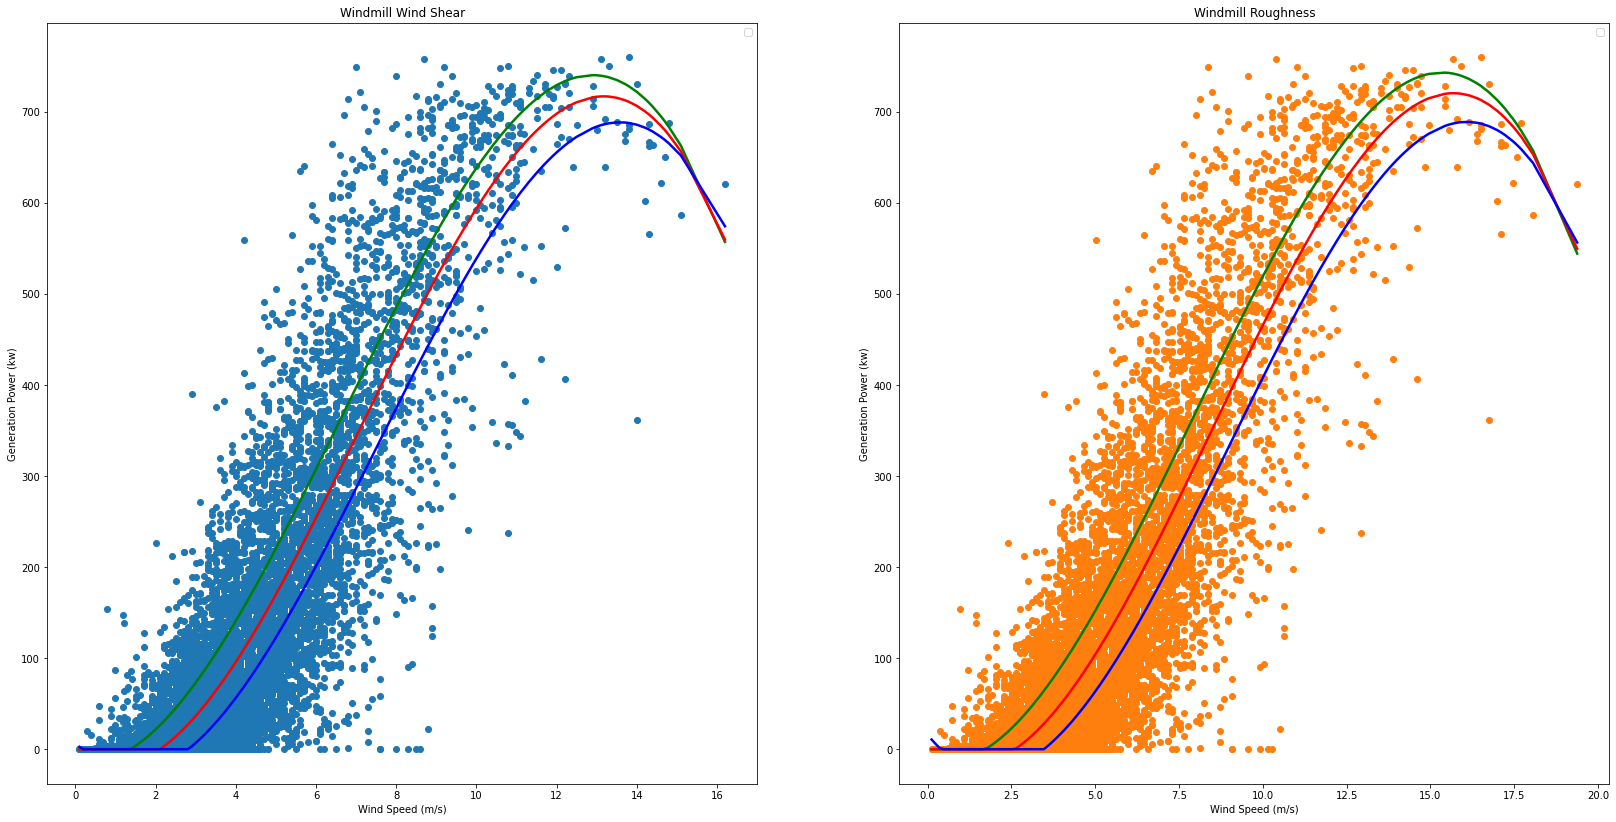

In [44]:
wind_power_scatter(df_wsr, df_rn)